# Compare LSTM - Transfomer

In [71]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import time

In [12]:
home_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/'
eval_dir = f'{home_dir}/Log/'

In [58]:
dirk_metrics = pd.read_csv(f'{home_dir}/postrun_eval_mrcNDO_bs64_embDO3e-1_AdamW1e-5_control.csv')


In [59]:
dirk_metrics = dirk_metrics[['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE']].reindex(range(1, 9)).drop(labels=[3,4,6,8])
dirk_metrics['Subject'] = dirk_metrics.index
cols = dirk_metrics.columns.tolist()
cols = cols[-1:] + cols[:-1]
dirk_metrics = dirk_metrics[cols]
dirk_metrics

,Subject,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE
1,1,0.547,0.352,0.221,0.140,0.158,0.402,0.388,0.081
2,2,0.512,0.307,0.178,0.107,0.141,0.372,0.278,0.063
5,5,0.499,0.306,0.179,0.106,0.145,0.374,0.285,0.070
7,7,0.493,0.294,0.175,0.108,0.137,0.372,0.270,0.062


In [110]:
sean_metrics = [
    [1, 0.453, 0.239 ,0.121 ,0.065, 0.114, 0.338, 0.110, 0.034],
    [2, 0.600, 0.412, 0.281, 0.194, 0.180, 0.442, 0.509, 0.102], # correct
    [5, 0.451, 0.233, 0.101, 0.049, 0.108, 0.333, 0.081, 0.022], 
    [7, 0.596, 0.405, 0.272, 0.184, 0.176, 0.439, 0.509, 0.098], # fixed
]
sean_metrics = pd.DataFrame(sean_metrics, columns=['Subject', 'Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'SPICE'])
sean_metrics

,Subject,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE
0,1,0.453,0.239,0.121,0.065,0.114,0.338,0.110,0.034
1,2,0.600,0.412,0.281,0.194,0.180,0.442,0.509,0.102
2,5,0.451,0.233,0.101,0.049,0.108,0.333,0.081,0.022
3,7,0.596,0.405,0.272,0.184,0.176,0.439,0.509,0.098


In [24]:
models = ['subject_1_baseline', 'subject_2_baseline2', 'subject_5_baseline', 'subject_7_baseline']
data = {}
for m in models:
    attn_maps = glob.glob(f"{eval_dir}/{m}/eval_out/attention_scores_*")[0]
    outputs   = glob.glob(f"{eval_dir}/{m}/eval_out/output_captions_*")[0]

    print(m, "---", outputs)


subject_1_baseline --- /home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_1_baseline/eval_out/output_captions_94.npy
subject_2_baseline2 --- /home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_captions_80.npy
subject_5_baseline --- /home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_5_baseline/eval_out/output_captions_96.npy
subject_7_baseline --- /home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_7_baseline/eval_out/output_captions_84.npy


In [23]:
data[models[0]][0]

(515, 15, 360)

In [63]:
f = glob.glob(f"{eval_dir}/subject_2_baseline2/eval_out/*.npy")
for i in f:
    print(i)

/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_captions_80.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80_doublecheck.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_guse.npy
/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/output_captions_80_doublecheck.npy


In [106]:
x1 = np.squeeze(np.load('/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80_doublecheck.npy'))
print(x1.shape)
x2 = np.squeeze(np.load('/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_2_baseline2/eval_out/attention_scores_80.npy'))
print(x2.shape)

x3 = np.squeeze(
    np.load(
        '/home/hpcgies1/Masters-Thesis/AttemptFour//Log//subject_7_baseline2/eval_out/attention_scores_80.npy'
    ))
print(x3.shape)

(515, 15, 360)
(515, 15, 360)
(515, 15, 360)


In [107]:
import cortex
import nibabel as nb

"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"

def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents

def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

load glasser masks: 0.04
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


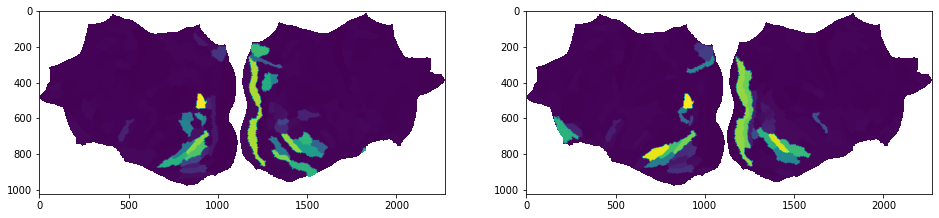

In [108]:

fig, ax = plt.subplots(1,2, figsize=(16,9))

# temp = x3[509,0]
# d = get_flatmap(generate_plot(temp))[0]
d = get_flatmap(generate_plot(np.mean(x3, axis=(0,1))))[0]
ax[0].imshow(d)
d = get_flatmap(generate_plot(np.mean(x2, axis=(0,1))))[0]
ax[1].imshow(d)
plt.show()

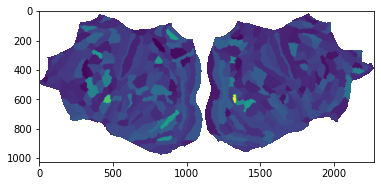

In [104]:
temp = 'subject_7_baseline' #'subject_2_baseline2'
temp = glob.glob(f"{eval_dir}/{temp}/eval_out/attention_scores_*.npy")[0]

x4 = np.squeeze(np.load(open(temp, 'rb')))

plt.figure()
d = get_flatmap(generate_plot(np.mean(x4, axis=(0,1))))[0]
plt.imshow(d)
plt.show()